In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import scipy
import matplotlib.pylab as plt
import seaborn as sns
import ast
import glob

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Set random seed
np.random.seed(314)

In [9]:
IMAGE_LOC = '/nvme/UCIAccData/'
activity_list = [i for i in glob.glob(f'{IMAGE_LOC}/*') if i.find('_') > 0 and "MODEL" not in i]

In [10]:
def read_data(activity_list):
    '''Read files in each activity in activity_list
    Returns dict: key = activity name -> array of numpy arrays of shape (n_observations, 3) = (ax,ay,az)
    '''
    data = {}
    
    for t in activity_list: #loop over each activity type
        activity_name = t.split('/')[-1]
        data[activity_name] = []
    
        filenames = glob.glob(t + '/*')
        
        for f in filenames: #loop over every participants time-series
            df = pd.read_csv(f, sep=' ', header=None)
            
            #ts = np.sqrt((df**2).sum(axis=1)) #magnitude of acceleration vector
            
            data[activity_name].append(np.array(df))
    
    return data

def get_acceleration_timeseries(data):
    '''Input: data returned by read_data
    Output: dictionary mapping activity name -> list of single time-series of acceleration magnitudes
    '''
    
    data_ts = {}
    
    for k in data:
        data_ts[k] = []
        
        for sample in data[k]: #(ax, ay, az)
            data_ts[k].append(np.sqrt((sample**2).sum(axis=1)))
    
    return data_ts

In [11]:
data_ts = read_data(activity_list)
data_ts = get_acceleration_timeseries(data_ts)

In [12]:
def featurize_stats(ts, bins):
    #basic statistical measures
    mean = np.mean(ts)
    median = np.median(ts)
    std = np.std(ts)
    length = len(ts)
    kurtosis = scipy.stats.kurtosis(ts)
    
    n,b,p = plt.hist(ts, bins=bins)
    n = np.array(n)/float(np.sum(n)) #normalize i.e. fraction of entries in each bin
    
    if median == 0: 
        features = {'mean_over_median': 0, #dimensionless            
                    'std_over_median': 0, #dimensionless            
                    'length': length,
                    'kurtosis': kurtosis, #already dimensionless by definition
                   }
        
    else: 
        features = {'mean_over_median': mean/median, #dimensionless            
            'std_over_median': std/median, #dimensionless            
            'length': length,
            'kurtosis': kurtosis, #already dimensionless by definition
           }
        
    for i, val in enumerate(n):
        features[f'binfrac_{i}'] = val
    
    return features

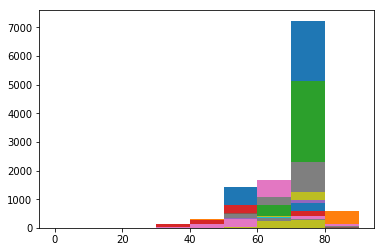

In [13]:
bins = np.arange(0,100,10)

df = []
labels = []

for k in data_ts: #slow, should parallelize
    for elem in data_ts[k]:
        df.append(featurize_stats(elem, bins))
        labels.append(k)

In [15]:
df = pd.DataFrame(df)
df['label'] = labels

In [16]:
df.shape

(739, 14)

In [17]:
train_df, test_df = train_test_split(df, train_size=0.75)

/home/sanjay/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [18]:
train_labels = np.array(train_df['label'])
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)

In [19]:
test_labels = np.array(test_df['label'])
label_encoder = LabelEncoder()
test_labels = label_encoder.fit_transform(test_labels)

In [20]:
X_train = train_df.drop('label', axis=1)
X_test = test_df.drop('label', axis=1)

## TF Random Forest Model

In [22]:
import tensorflow as tf
from tensorflow.python.ops import resources
from tensorflow.contrib.tensor_forest.python import tensor_forest

import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

ImportError: Traceback (most recent call last):
  File "/home/sanjay/.local/lib/python3.6/site-packages/tensorflow/python/pywrap_tensorflow.py", line 58, in <module>
    from tensorflow.python.pywrap_tensorflow_internal import *
  File "/home/sanjay/.local/lib/python3.6/site-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 28, in <module>
    _pywrap_tensorflow_internal = swig_import_helper()
  File "/home/sanjay/.local/lib/python3.6/site-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 24, in swig_import_helper
    _mod = imp.load_module('_pywrap_tensorflow_internal', fp, pathname, description)
  File "/usr/lib64/python3.6/imp.py", line 243, in load_module
    return load_dynamic(name, filename, file)
  File "/usr/lib64/python3.6/imp.py", line 343, in load_dynamic
    return _load(spec)
ImportError: libcublas.so.9.0: cannot open shared object file: No such file or directory


Failed to load the native TensorFlow runtime.

See https://www.tensorflow.org/install/errors

for some common reasons and solutions.  Include the entire stack trace
above this error message when asking for help.

In [13]:
# Params 

num_steps = 1000 # training steps
batch_size = 100 # number of sampels per batch
num_classes = 14 # number of classes to categorize 
num_features = 13 # size of the input data
num_trees = 81 # number of trees in our forest
max_nodes = 400 # maximum number of nodes (per tree ?)

#Data

X = tf.placeholder(tf.float32, shape=[None,num_features])
# For random forest, labels must be integers (the class id)
y = tf.placeholder(tf.int32, shape=[None])

# Random Forest Parameters

hparams = tensor_forest.ForestHParams(num_classes=num_classes,
                                     num_features=num_features,
                                     num_trees=num_trees,
                                     max_nodes=max_nodes).fill()

In [14]:
forest_graph = tensor_forest.RandomForestGraphs(hparams)

# Get training graph and loss
train_op = forest_graph.training_graph(X,y)
loss_op = forest_graph.training_loss(X,y)

# Measure Accuracy
infer_op, _, _ = forest_graph.inference_graph(X)
correct_prediction = tf.equal(tf.argmax(infer_op,1), tf.cast(y, tf.int64))
accuracy_op = tf.reduce_mean(tf.cast(correct_prediction,tf.float32))

#Initilize variables
init_vars = tf.group(tf.global_variables_initializer(),
                     resources.initialize_resources(resources.shared_resources()))

INFO:tensorflow:Constructing forest with params = 
INFO:tensorflow:{'num_trees': 81, 'max_nodes': 400, 'bagging_fraction': 1.0, 'feature_bagging_fraction': 1.0, 'num_splits_to_consider': 10, 'max_fertile_nodes': 0, 'split_after_samples': 250, 'valid_leaf_threshold': 1, 'dominate_method': 'bootstrap', 'dominate_fraction': 0.99, 'model_name': 'all_dense', 'split_finish_name': 'basic', 'split_pruning_name': 'none', 'collate_examples': False, 'checkpoint_stats': False, 'use_running_stats_method': False, 'initialize_average_splits': False, 'inference_tree_paths': False, 'param_file': None, 'split_name': 'less_or_equal', 'early_finish_check_every_samples': 0, 'prune_every_samples': 0, 'num_classes': 14, 'num_features': 13, 'bagged_num_features': 13, 'bagged_features': None, 'regression': False, 'num_outputs': 1, 'num_output_columns': 15, 'base_random_seed': 0, 'leaf_model_type': 0, 'stats_model_type': 0, 'finish_type': 0, 'pruning_type': 0, 'split_type': 0}


In [15]:
# Start session
sess = tf.train.MonitoredSession()

# Run initializer
sess. run(init_vars)

# Train
for i in range(1, num_steps + 1):
    _, l = sess.run([train_op, loss_op], feed_dict={X: X_train, y: train_labels})
    
    if i % 50 == 0 or i == 1:
        acc = sess.run(accuracy_op,feed_dict={X: X_train, y: train_labels})
        print('Step %i, Loss: %f, ACC: %f' % (i, l, acc))
        
print("Test Accuracy:", sess.run(accuracy_op, feed_dict={X: X_test, y: test_labels}))

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Step 1, Loss: -1.000000, ACC: 0.434022
Step 50, Loss: -156.135803, ACC: 0.896661
Step 100, Loss: -285.765442, ACC: 0.980922
Step 150, Loss: -379.098755, ACC: 1.000000
Step 200, Loss: -400.925934, ACC: 1.000000
Step 250, Loss: -401.000000, ACC: 1.000000
Step 300, Loss: -401.000000, ACC: 1.000000
Step 350, Loss: -401.000000, ACC: 1.000000
Step 400, Loss: -401.000000, ACC: 1.000000
Step 450, Loss: -401.000000, ACC: 1.000000
Step 500, Loss: -401.000000, ACC: 1.000000
Step 550, Loss: -401.000000, ACC: 1.000000
Step 600, Loss: -401.000000, ACC: 1.000000
Step 650, Loss: -401.000000, ACC: 1.000000
Step 700, Loss: -401.000000, ACC: 1.000000
Step 750, Loss: -401.000000, ACC: 1.000000
Step 800, Loss: -401.000000, ACC: 1.000000
Step 850, Loss: -401.000000, ACC: 1.000000
Step 900, Loss: -401.000000, ACC: 1.000000
Step 950, Loss: -401.000000, ACC: 1.000000
Step 1000, Loss: -401.000